## Cloning the repository which has the dataset:

In [0]:
#cloning repository which has the dataset
!git clone https://github.com/loicmarie/sign-language-alphabet-recognizer.git

Cloning into 'sign-language-alphabet-recognizer'...
remote: Enumerating objects: 87087, done.
remote: Total 87087 (delta 0), reused 0 (delta 0), pack-reused 87087
Receiving objects: 100% (87087/87087), 1.01 GiB | 38.81 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Checking out files: 100% (87008/87008), done.


In [0]:
%cd sign-language-alphabet-recognizer/

/content/sign-language-alphabet-recognizer


In [0]:
!ls

classify.py	    dataset	LICENSE    requirements.txt
classify_webcam.py  Dockerfile	README.md  train.py


# fun begins

In [0]:
import tensorflow as tf

### Preprocess and flow training images in batches of 150 from directory using ImageDataGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 150 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'dataset',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=150, # 150 divides 87000
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 87000 images belonging to 29 classes.


### Build the neural network

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 29 output neurons, one for each class.
    tf.keras.layers.Dense(29, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0         
__________

### define the callback and train the model

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    acc=0.99
    if(logs.get('acc')>acc):
      print(f"\nReached {acc*100}% accuracy so cancelling training!")
      self.model.stop_training = True
callback=myCallback()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=580, #87500 images/150(batch size)  
      epochs=100, # hopefully doesnt do ALL 100, should stop when reaches desired accuracy
      callbacks=[callback],
      verbose=1,)

Epoch 1/100
580/580 [==============================] - 193s 332ms/step - loss: 0.7788 - acc: 0.7692
Epoch 2/100
580/580 [==============================] - 190s 328ms/step - loss: 0.0720 - acc: 0.9775
Epoch 3/100
580/580 [==============================] - 190s 327ms/step - loss: 0.0321 - acc: 0.9898
Epoch 4/100
579/580 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9939
Reached 99.0% accuracy so cancelling training!
580/580 [==============================] - 189s 327ms/step - loss: 0.0218 - acc: 0.9939


### Running and predicting with the model

In [0]:
from string import ascii_uppercase
#unique classes-> have labels 0-28
print(sorted(list(set(list(train_generator.classes)))))
#mapping them to what they represent
labelToVal=dict(zip(range(29), [x for x in ascii_uppercase]+['del','nothing','space']))
labelToVal

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'nothing',
 28: 'space'}

In [0]:
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys(): 
#   # predicting images
#   path = fn
#   img = image.load_img(path, target_size=(150,150))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
# #   print(classes[0])
#   l_classes=list(classes[0])
#   predicted=labelToVal[l_classes.index(max(l_classes))]
#   print(f'The model has classified this as -> {predicted}')
  

### visualizing intermediate steps

In [0]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import matplotlib.pyplot as plt
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]] ## can do this!
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
A_files = [os.path.join('dataset/A', f) for f in os.listdir('dataset/A')]
B_files = [os.path.join('dataset/B', f) for f in os.listdir('dataset/B')]
C_files = [os.path.join('dataset/C', f) for f in os.listdir('dataset/C')]
D_files = [os.path.join('dataset/D', f) for f in os.listdir('dataset/D')]
E_files = [os.path.join('dataset/E', f) for f in os.listdir('dataset/E')]
F_files = [os.path.join('dataset/F', f) for f in os.listdir('dataset/F')]
G_files = [os.path.join('dataset/G', f) for f in os.listdir('dataset/G')]
H_files = [os.path.join('dataset/H', f) for f in os.listdir('dataset/H')]
I_files = [os.path.join('dataset/I', f) for f in os.listdir('dataset/I')]
J_files = [os.path.join('dataset/J', f) for f in os.listdir('dataset/J')]
K_files = [os.path.join('dataset/K', f) for f in os.listdir('dataset/K')]
L_files = [os.path.join('dataset/L', f) for f in os.listdir('dataset/L')]
M_files = [os.path.join('dataset/M', f) for f in os.listdir('dataset/M')]
N_files = [os.path.join('dataset/N', f) for f in os.listdir('dataset/N')]
O_files = [os.path.join('dataset/O', f) for f in os.listdir('dataset/O')]
P_files = [os.path.join('dataset/P', f) for f in os.listdir('dataset/P')]
Q_files = [os.path.join('dataset/Q', f) for f in os.listdir('dataset/Q')]
R_files = [os.path.join('dataset/R', f) for f in os.listdir('dataset/R')]
S_files = [os.path.join('dataset/S', f) for f in os.listdir('dataset/S')]
T_files = [os.path.join('dataset/T', f) for f in os.listdir('dataset/T')]
U_files = [os.path.join('dataset/U', f) for f in os.listdir('dataset/U')]
V_files = [os.path.join('dataset/V', f) for f in os.listdir('dataset/V')]
W_files = [os.path.join('dataset/W', f) for f in os.listdir('dataset/W')]
X_files = [os.path.join('dataset/X', f) for f in os.listdir('dataset/X')]
Y_files = [os.path.join('dataset/Y', f) for f in os.listdir('dataset/Y')]
Z_files = [os.path.join('dataset/Z', f) for f in os.listdir('dataset/Z')]
allFilePaths=A_files+B_files+C_files+D_files+E_files+F_files+G_files+H_files+I_files+J_files+K_files+L_files+M_files+N_files+O_files+P_files+Q_files+R_files+S_files+T_files+U_files+V_files+W_files+X_files+Y_files+Z_files

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


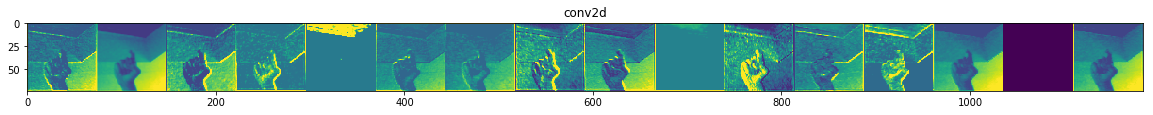

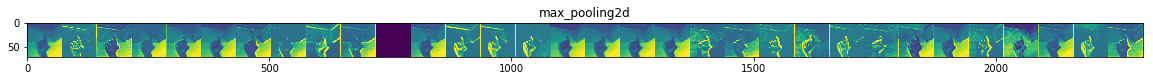

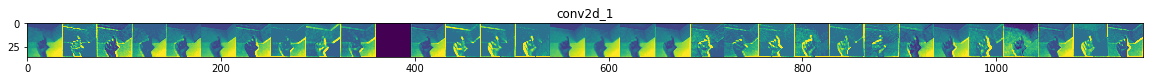

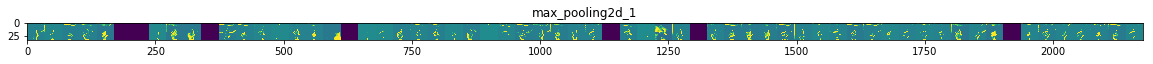

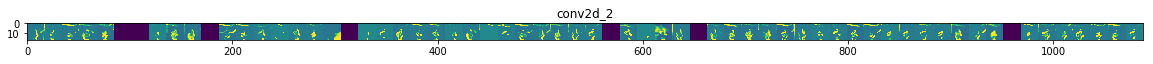

In [0]:
img_path = random.choice(allFilePaths)

img = load_img(img_path, target_size=(150,150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Saving the model

In [0]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("final_model.h5")

from google.colab import files
files.download("final_model.json") # saves the architecture of the model
files.download('final_model.h5') # saves the weights of the model

print("Saved model to disk")

Saved model to disk


# to load model back 

In [0]:
import tensorflow as tf
tf.keras.models.model_from_json

<module 'tensorflow.python.keras.api._v2.keras' from '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/api/_v2/keras/__init__.py'>

In [0]:
import tensorflow as tf
json_file = open('final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights('final_model.h5')
loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# to save in tensorflow.js format

In [0]:
!pip install tensorflowjs 

In [0]:
!mkdir tfjs_version

In [0]:
!ls

sample_data  sign-language-alphabet-recognizer


In [0]:
!pip install --upgrade numpy 

     |████████████████████████████████| 17.3MB 3.4MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
ERROR: tensorflowjs 1.0.1 has requirement numpy==1.15.1, but you'll have numpy 1.16.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.15.1
    Uninstalling numpy-1.15.1:
      Successfully uninstalled numpy-1.15.1


In [0]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(loaded_model, "tfjs_version")

In [0]:
!zip -r tfjs_version.zip tfjs_version

  adding: tfjs_version/ (stored 0%)
  adding: tfjs_version/group1-shard8of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard4of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard9of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard10of10.bin (deflated 7%)
  adding: tfjs_version/model.json (deflated 82%)
  adding: tfjs_version/group1-shard5of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard7of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard3of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard6of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard2of10.bin (deflated 7%)
  adding: tfjs_version/group1-shard1of10.bin (deflated 7%)
